# Directed Networks

The directedness of edges dramatically affects almost all network measures and structural elements. Let’s have a look at some affected properties. As an example, let’s use a directed network of the top three preferred migration destinations for each state in 2015, constructed from the United States Census Bureau State-to-State Migration Flows dataset. (remember to copy files **migration.csv** and **states.csv** in the working directory)

In [3]:
import pandas as pd
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
import matplotlib.pyplot as plt
import dzcnapy_plotlib as dzcnapy

In [4]:
migrations = pd.read_csv("migration_2015.csv",
                         thousands=",").set_index("Unnamed: 0")

table_migrations = migrations.stack().reset_index()\
                                     .sort_values(0, ascending=False)\
                                     .groupby("Unnamed: 0").head(3)

table_migrations.columns = "From", "To", "weight"

G = nx.from_pandas_dataframe(table_migrations, "From", "To", 
                             edge_attr=["weight"],
                             create_using=nx.DiGraph())
nx.relabel_nodes(G, pd.read_csv("states.csv", header=None)\
                 .set_index(0)[2].to_dict(), copy=False)

## Degree

The indegree and total degrees of the migration graph designate the most attractive destinations (which are, not surprisingly, sunny California, Florida, and Texas). By construction, all nodes have the same outdegree of 3.

In [5]:
sorted(G.in_degree(), key=lambda x: x[1], reverse=True)[:3]

[('CA', 21), ('FL', 17), ('TX', 16)]

In [6]:
sorted(G.out_degree(),key=lambda x: x[1], reverse=True)[:3]

[('DC', 3), ('HI', 3), ('TN', 3)]

In [7]:
sorted(G.degree(),    key=lambda x: x[1], reverse=True)[:3]

[('CA', 24), ('FL', 20), ('TX', 19)]

## Neighbors

A node in a directed graph has two types of neighbors: **G.successors** (reachable through the outgoing edges) and **G.predecessors** (reachable through the incoming edges). The method **G.neighbors** is another name of **G.successors**. In the migration network, the successors of the **final_destination** (_CA_) are the preferred destinations of the outgoing migration. The successors are the states from which migrants come to California.

In [8]:
final_destination = sorted(G.in_degree(), key=lambda x: x[1],
                           reverse=True)[0][0]
coming_from = G.predecessors(final_destination)

In [9]:
list(coming_from)

['HI',
 'NV',
 'CO',
 'AZ',
 'NY',
 'AK',
 'ID',
 'KS',
 'UT',
 'MT',
 'OK',
 'ND',
 'NM',
 'WA',
 'MA',
 'MO',
 'LA',
 'TX',
 'IL',
 'OR',
 'VA']

In [10]:
going_to = G.successors(final_destination)
list(going_to)

['AZ', 'NY', 'TX']

## Components

A directed network has two types of components. In a strongly connected component, any member node is reachable from any other member node. (There is a migration flow from any state to any state, perhaps through some intermediate states in the same component.) In a weakly connected component, any member node would be reachable from any other member node if all edges were converted to undirected. (There is a migration flow either from or to any state, perhaps through some intermediate states in the same component.)

In [11]:
print(sorted(nx.weakly_connected_components(G), key=len, reverse=True))
print(sorted(nx.strongly_connected_components(G), key=len, reverse=True))

[{'WY', 'KY', 'MT', 'AL', 'ND', 'AK', 'WV', 'MN', 'VT', 'CO', 'UT', 'LA', 'NM', 'NH', 'ID', 'IL', 'TN', 'MI', 'RI', 'FL', 'NE', 'MD', 'CT', 'WI', 'WA', 'DE', 'OH', 'NY', 'DC', 'ME', 'MA', 'VA', 'SC', 'CA', 'KS', 'IN', 'OR', 'HI', 'NV', 'IA', 'NC', 'NJ', 'TX', 'SD', 'MS', 'MO', 'PA', 'OK', 'AZ', 'AR', 'GA', 'PR'}]
[{'KY', 'GA', 'UT', 'LA', 'TN', 'IL', 'ID', 'FL', 'MD', 'WA', 'OH', 'NY', 'DC', 'VA', 'SC', 'IN', 'KS', 'CA', 'OR', 'NC', 'NJ', 'TX', 'MS', 'MO', 'PA', 'AZ', 'MI'}, {'ND', 'NE', 'MN', 'WI', 'IA'}, {'ME', 'NH'}, {'HI'}, {'NV'}, {'CO'}, {'WY'}, {'OK'}, {'AR'}, {'MA'}, {'CT'}, {'AL'}, {'AK'}, {'WV'}, {'DE'}, {'MT'}, {'PR'}, {'NM'}, {'VT'}, {'SD'}, {'RI'}]


Function **nx.condensation(G)** calculates the condensation of G. A condensation is an induced directed graph whose nodes represent strongly connected components of G, and edges represent bundles of the original edges. All original graph nodes within an induced node of the condensation are definitely reachable from each other. If your goal is to study graph reachability, replacing a strongly connected component with one node does not affect your findings, but makes the problem simpler.

A strongly connected component is called attracting if it has no outgoing edges whatsoever. **NetworkX** offers functions **nx.attracting_components(G)** and **nx.attracting_component_subgraphs(G)** to obtain the attracting components. The plot shows the nodes in the attracting component in green. Once you move into a “green” state, you will likely stay in the “green” state for good.

{'KY', 'GA', 'UT', 'LA', 'TN', 'IL', 'ID', 'FL', 'MD', 'WA', 'OH', 'NY', 'DC', 'VA', 'SC', 'IN', 'KS', 'CA', 'OR', 'NC', 'NJ', 'TX', 'MS', 'MO', 'PA', 'AZ', 'MI'}


/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['Liberation Sans Narrow'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


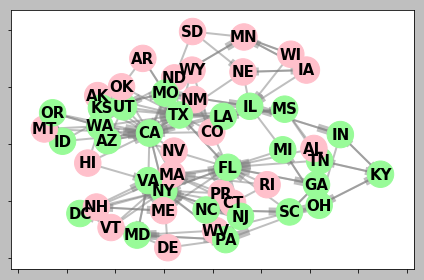

In [12]:
attracting = sorted(nx.attracting_components(G), key=len, reverse=True)[0]
print(attracting)

pos = graphviz_layout(G)
dzcnapy.attrs["node_color"] = ["palegreen" if n in attracting 
                               else "pink" for n in G]

nx.draw_networkx_edges(G, pos, alpha=0.5, **dzcnapy.attrs)
nx.draw_networkx_nodes(G, pos, **dzcnapy.attrs)
nx.draw_networkx_labels(G, pos, **dzcnapy.attrs)

dzcnapy.set_extent(pos, plt)
dzcnapy.plot("migration", True)

## Reversal and Flattening

You can reverse a directed graph with the method **G.reverse**. The function returns a copy of the original graph with each edge reversed. The indegrees, outdegrees, successors, and predecessors in the new graph are the outdegrees, indegrees, predecessors, and successors of the original graph, respectively. Both graphs have the same weakly and strongly connected components. If your graph represents consequences for each cause, the reversed one shows all the causes for each consequence.

Finally, **NetworkX** provides a tool for getting rid of directedness altogether. Method **G.to_undirected(reciprocal=False)** returns an undirected copy of a directed graph. If the parameter reciprocal is True, then the function connects two nodes with an undirected edge only if they are already connected by a pair of antiparallel directed edges. Otherwise, directed edges are demoted to undirected edges, and any possible resulting pairs of parallel edges are merged.